In [1]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import librosa

import sys
sys.path.append('../..')
import libfmp.b
import libfmp.c3
import libfmp.c4
import libfmp.c5
%matplotlib inline

data_basedir = os.path.join('.', 'data', 'dChord')

import torch 
import torch.nn.functional as F
from torchinfo import summary

from copy import deepcopy
from torch.utils.data import Dataset, ConcatDataset, DataLoader

## Network configuration

In [2]:
# code copied from libdl.nn_models.cnns_chord_recog

class log_compression(torch.nn.Module):
    """Module for logarithmic compression of an array

    Args:
        gamma: Compression factor
        trainable: Whether the gradient w.r.t. gamma is computed in backward pass
    """
    def __init__(self, gamma_init=1, trainable=True):
        super(log_compression, self).__init__()

        # define logarithm of gamma as trainable parameter
        if gamma_init is not None:
            self.log_gamma = torch.nn.parameter.Parameter(data=torch.log(torch.as_tensor(gamma_init, dtype=torch.float32)), requires_grad=trainable)
        else:
            self.log_gamma = None

    def forward(self, x):
        if self.log_gamma is not None:
            # gamma = torch.exp(torch.clamp(self.log_gamma, max=5.0))
            return torch.log(1.0 + torch.exp(self.log_gamma) * x + 1e-10)
        else:
            return x


class gaussian_filter(torch.nn.Module):
    """Module for generating a 1D Gaussian filter

    Args:
        length: kernel length
        sigma: (initial) standard deviation for Gaussian kernel
        dim: dimension across which to apply the filter; output tensor will have singleton dimension at 'dim'
        trainable: whether to optimize the standard deviation
    """
    def __init__(self, length=41, sigma_init=1, dim=2, trainable=True):
        super(gaussian_filter, self).__init__()

        self.length = length
        self.dim = dim

        if sigma_init is None:
            sigma_init = length
        self.log_sigma = torch.nn.parameter.Parameter(data=torch.log(torch.as_tensor(sigma_init, dtype=torch.float32)), requires_grad=trainable)

    def forward(self, x):
        idx = x.ndim * [1]
        idx[self.dim] = self.length
        w = self.get_kernel()
        x_smoothed = torch.sum(x * w.view(*idx), dim=self.dim, keepdim=True)
        return x_smoothed

    def get_kernel(self):
        n = torch.arange(0, self.length).to(self.log_sigma.device) - (self.length - 1.0) / 2.0
        sig2 = 2 * torch.exp(self.log_sigma) ** 2
        w = torch.exp(-n ** 2 / sig2)
        return w / torch.sum(w)


class temporal_smoothing(torch.nn.Module):
    """Module for temporal smoothing of a feature sequence.

    Args:
        smoothing_type: Either 'weighted_sum', 'median' or 'Gaussian'
        avg_length: Length to be averaged over; only relevant for 'weighted_sum' and 'Gaussian' (median is taken over whole input length)
        weight_init: How to initialize (trainable) weights, only relevant for 'weighted_sum' (either 'uniform' or 'random')
    """
    def __init__(self, smoothing_type='weighted_sum', avg_length=41, weight_init='uniform', sigma_init=20):
        super(temporal_smoothing, self).__init__()
        if smoothing_type not in {'weighted_sum', 'median', 'Gaussian'}:
            raise ValueError('Smoothing type ' + smoothing_type + ' is unknown!')

        if weight_init not in {'random', 'uniform'}:
            raise ValueError('Weight initialization ' + weight_init + ' is unknown!')

        self.avg_length = avg_length

        if smoothing_type == 'weighted_sum':
            self.filter = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(avg_length, 1),
                                    stride=(1, 1), bias=False, padding='valid')

            if weight_init == 'random':
                pass
            elif weight_init == 'uniform':
                self.filter.weight.data = torch.ones_like(self.filter.weight.data) / avg_length

        elif smoothing_type == 'median':
            self.filter = lambda x: torch.median(x, dim=2, keepdim=True,).values

        elif smoothing_type == 'Gaussian':
            self.filter = gaussian_filter(length=avg_length, sigma_init=sigma_init, dim=2, trainable=True)

    def forward(self, x):
        # treat channels as batch dimension to use conv. layer with 1 channel
        x_reshaped = x.view(-1, 1, *x.shape[2:])
        x_filtered = self.filter(x_reshaped)
        return x_filtered.view(*x.shape[:2], *x_filtered.shape[2:])


class feature_normalization(torch.nn.Module):
    """Module for feature normalization

    Args:
        num_features: Number of features
        norm: The norm to be applied. '1', '2', 'max' or 'z'
        threshold: Threshold below which the vector `v` is used instead of normalization
        v: Used instead of normalization below `threshold`. If None, uses unit vector for given norm
    """
    def __init__(self, num_features=12, norm='2', threshold=1e-4, v=None, dim=3):
        super(feature_normalization, self).__init__()
        if norm not in ['1', '2', 'max', 'z']:
            raise ValueError('Norm ' + norm + ' is unknown!')

        self.threshold = threshold
        self.v = v

        if norm == '1':
            if self.v is None:
                self.v = torch.ones(num_features, dtype=torch.float32) / num_features
            self.get_norms = lambda x: torch.linalg.vector_norm(x, ord=1.0, dim=dim, keepdim=False)
            self.normalize = lambda x: F.normalize(x, p=1.0, dim=dim, eps=threshold)

        if norm == '2':
            if self.v is None:
                self.v = torch.ones(num_features, dtype=torch.float32) / torch.sqrt(torch.tensor([num_features]))
            self.get_norms = lambda x: torch.linalg.vector_norm(x, ord=2.0, dim=dim, keepdim=False)
            self.normalize = lambda x: F.normalize(x, p=2.0, dim=dim, eps=threshold)

        if norm == 'max':
            if self.v is None:
                self.v = torch.ones(num_features, dtype=torch.float32)
            self.get_norms = lambda x: torch.linalg.vector_norm(x, ord=float('inf'), dim=dim, keepdim=False)
            self.normalize = lambda x: F.normalize(x, p=float('inf'), dim=dim, eps=threshold)

        if norm == 'z':
            if self.v is None:
                self.v = torch.zeros(num_features)
            self.get_norms = lambda x: torch.std(x, dim=dim, keepdim=False, unbiased=True)
            self.normalize = lambda x: (x - torch.mean(x, dim=dim, keepdim=True)) / torch.std(x, dim=dim, keepdim=True,
                                                                                              unbiased=True)
    def forward(self, x):
        x_norms = self.get_norms(x)
        idx = x_norms > self.threshold
        x_normalized = x.clone()
        x_normalized = self.normalize(x_normalized)
        x_normalized[~idx] = self.v.to(x.device)
        return x_normalized


class chord_recognition_templates(torch.nn.Module):
    """Module for applying template-based chord recognition to chroma features.

    Args:
        shared_weights: Whether to use 2 shared kernels (maj/min) or 24 individual chord templates + 1 non chord template
        initialize_parameters: Whether to initialize kernels with idealized binary chord templates and zero bias
        normalize_weights: Whether to normalize all templates to unit Euclidean norm
        bias: Whether to allow for a trainable bias
    """
    def __init__(self, shared_weights=True, initialize_parameters=True, normalize_weights=True, bias=False):
        super(chord_recognition_templates, self).__init__()
        self.shared_weights = shared_weights

        if shared_weights:
            self.padding = lambda x: F.pad(x, pad=(0, 11, 0, 0), mode='circular')
            self.filter = torch.nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(1, 12), stride=(1, 1), bias=bias)
            self.blank_filter = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1, 12), stride=(1, 1), bias=bias)
            if initialize_parameters:
                self.filter.weight.data = torch.tensor([[[[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]]],     # major
                                                        [[[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]]]],    # minor
                                                       dtype=torch.float32)
                self.blank_filter.weight.data = torch.ones((1, 1, 1, 12), dtype=torch.float32) / 12.0
                if self.filter.bias is not None:
                    self.filter.bias.data = torch.zeros_like(self.filter.bias.data, dtype=torch.float32)
                if self.blank_filter.bias is not None:
                    self.blank_filter.bias.data = torch.zeros_like(self.blank_filter.bias.data, dtype=torch.float32)

        else:
            self.padding = lambda x: x
            self.filter = torch.nn.Conv2d(in_channels=1, out_channels=25, kernel_size=(1, 12), stride=(1, 1), bias=bias)
            if initialize_parameters:
                kernel_major = torch.tensor([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])
                kernel_minor = torch.tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])

                for i in range(12):
                    self.filter.weight.data[i, 0, 0, :] = torch.roll(kernel_major, i)
                    self.filter.weight.data[12 + i, 0, 0, :] = torch.roll(kernel_minor, i)
                # self.filter.weight.data[24, 0, 0, :] = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) / 12.0
                self.filter.weight.data[24, 0, 0, :] = torch.ones(12, dtype=torch.float32) / 12.0

                if self.filter.bias is not None:
                    self.filter.bias.data = torch.zeros_like(self.filter.bias.data, dtype=torch.float32)

        if normalize_weights:
            self.filter.weight.data = F.normalize(self.filter.weight.data, p=2.0, dim=3)

    def forward(self, x):
        if self.shared_weights:
            x_padded = self.padding(x)                                         # out: (B x 1 x T x 23)
            y = self.filter(x_padded)                                          # out: (B x 2 x T x 12)
            y_blank = self.blank_filter(x)                                     # out: (B x 1 x T x 1)
            y_reshaped = torch.swapaxes(y, 1, 2)                               # out: (B x T x 2 x 12)
            y_reshaped = torch.flatten(y_reshaped, start_dim=2)                # out: (B x T x 24)
            y_blank_reshaped = torch.swapaxes(y_blank, 1, 2)                                  # out: (B x T x 1 x 1)
            y_blank_reshaped = torch.squeeze(y_blank_reshaped, dim=2)                         # out: (B x T x 1)
            y_reshaped = torch.cat((y_reshaped, y_blank_reshaped), dim=2)                     # out: (B x T x 25)
            y_reshaped = torch.unsqueeze(y_reshaped, 1)                                       # out: (B x 1 x T x 25)
        else:
            x_padded = self.padding(x)                                          # out: (B x 1 x T x 12)
            y = self.filter(x_padded)                                           # out: (B x 25 x T x 1)
            y_reshaped = torch.swapaxes(y, 1, 2)                                # out: (B x T x 25 x 1)
            y_reshaped = torch.unsqueeze(torch.flatten(y_reshaped, start_dim=2), 1)             # out: (B x 1 x T x 25)
            
        return y_reshaped


class softmax_temperature(torch.nn.Module):
    """Softmax activation with trainable temperature parameter

    Args:
        dim: Dimension across which to apply the softmax function
        tau: Temperature parameter
        trainable: Whether the gradient w.r.t. tau is computed in backward pass
    """
    def __init__(self, dim=3, tau=1, trainable=True):
        super(softmax_temperature, self).__init__()
        self.dim = dim
        self.tau = torch.nn.parameter.Parameter(data=torch.tensor([tau], dtype=torch.float32), requires_grad=trainable)

    def forward(self, x):
        return F.softmax(x / self.tau, dim=self.dim)


class chord_recog_templates_pipeline(torch.nn.Module):
    """Model for template-based chord recognition:

    Pipeline:
        1) input: chroma features
        2) log compression (gamma trainable)
        3) NOT USED: temporal averaging (conv. layer with trainable weights / median filter / Gaussian filter)
        4) l1/l2/max/z normalization (only if norm large enough; otherwise: unit-norm vector with same values)
        5) chord recognition via templates (conv. layer)
        6) softmax -> output: chord probabilities

    Args:
        dictionaries containing parameters for the individual building blocks
    """
    def __init__(self, compression_params=None, temp_smooth_params=None, feature_norm_params=None,
                 chord_template_params=None, softmax_params=None):

        super(chord_recog_templates_pipeline, self).__init__()

        self.log_compression = log_compression(**compression_params)
        # self.temporal_smoothing = temporal_smoothing(**temp_smooth_params)
        self.feature_normalization = feature_normalization(**feature_norm_params)
        self.chord_recognition_templates = chord_recognition_templates(**chord_template_params)
        self.softmax_temperature = softmax_temperature(**softmax_params)

    def forward(self, x):
        y_pred, _, _, _, _ = self.get_intermediate_data(x)
        return y_pred

    def get_intermediate_data(self, x):
        # Check input
        # print("Input x contains NaN:", torch.isnan(x).any().item(), "inf:", torch.isinf(x).any().item())
        
        x_comp = self.log_compression(x)
        # print("After log_compression contains NaN:", torch.isnan(x_comp).any().item(), "inf:", torch.isinf(x_comp).any().item())

        x_avg = x_comp
        # x_avg = self.temporal_smoothing(x_comp)
        # print("After temporal_smoothing contains NaN:", torch.isnan(x_avg).any().item(), "inf:", torch.isinf(x_avg).any().item())
        
        x_normalized = self.feature_normalization(x_avg)
        # print("After feature_normalization contains NaN:", torch.isnan(x_normalized).any().item(), "inf:", torch.isinf(x_normalized).any().item())
        
        x_templates = self.chord_recognition_templates(x_normalized)
        # print("After chord_recognition_templates contains NaN:", torch.isnan(x_templates).any().item(), "inf:", torch.isinf(x_templates).any().item())
        
        y_pred = self.softmax_temperature(x_templates)
        # print("After softmax_temperature contains NaN:", torch.isnan(y_pred).any().item(), "inf:", torch.isinf(y_pred).any().item())
        
        return y_pred, x_templates, x_normalized, x_avg, x_comp

In [3]:
# Pipeline config

compression_params = {'gamma_init': 1.0,       # makes pipeline somehow redundant; input chroma features are already logarithmically compressed
                      'trainable': True}

# temp_smooth_params = {'smoothing_type': 'weighted_sum', 
#                       'avg_length': 51, 
#                       'weight_init': 'uniform'}

# temp_smooth_params = {'smoothing_type': 'Gaussian', 
#                       'avg_length': 51, 
#                       'sigma_init': 50}

feature_norm_params = {'num_features': 12,
                       'norm': '2', 
                       'threshold': 1e-4}

chord_template_params = {'shared_weights': True, 
                         'initialize_parameters': True, 
                         'normalize_weights': False}

softmax_params = {'tau': 1, 
                  'trainable': False}

model_pipeline = chord_recog_templates_pipeline(compression_params=compression_params, 
                                       # temp_smooth_params=temp_smooth_params, 
                                       feature_norm_params=feature_norm_params, 
                                       chord_template_params=chord_template_params, 
                                       softmax_params=softmax_params)

In [4]:
summary(model_pipeline, input_size=(1, 1, 40, 12))

Layer (type:depth-idx)                   Output Shape              Param #
chord_recog_templates_pipeline           [1, 1, 40, 25]            --
├─log_compression: 1-1                   [1, 1, 40, 12]            1
├─feature_normalization: 1-2             [1, 1, 40, 12]            --
├─chord_recognition_templates: 1-3       [1, 1, 40, 25]            --
│    └─Conv2d: 2-1                       [1, 2, 40, 12]            24
│    └─Conv2d: 2-2                       [1, 1, 40, 1]             12
├─softmax_temperature: 1-4               [1, 1, 40, 25]            (1)
Total params: 38
Trainable params: 37
Non-trainable params: 1
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

## The END of network configuration
## -------------------------------------------------------------------------------------------------------

## Prepare data

In [5]:
nonchord = False
song_dict = {}
# song_dict[0] = ['LetItB', 'r',
#                 os.path.join(data_basedir, 'C5', 'FMP_C5_Audio_Beatles_LetItBe_Beatles_1970-LetItBe-06.wav'),
#                 os.path.join(data_basedir, 'C5', 'FMP_C5_Audio_Beatles_LetItBe_Beatles_1970-LetItBe-06_Chords_simplified.csv')]
song_dict[0] = ['LetItB', 'r',
                os.path.join(data_basedir, 'FMP_C5_F01_Beatles_LetItBe-mm1-4_Original.wav'),
                os.path.join(data_basedir, 'FMP_C5_F01_Beatles_LetItBe-mm1-4_Original_Chords_simplified.csv')]
song_dict[1] = ['HereCo', 'b',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07_Chords_simplified.csv')]
song_dict[2] = ['ObLaDi', 'c',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04_Chords_simplified.csv')]
song_dict[3] = ['PennyL', 'g',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09_Chords_simplified.csv')]

# csv_rel_path = song_dict[0][3]
# csv_abs_path = os.path.abspath(csv_rel_path)
# print(csv_abs_path)

### Feature Extraction (log-compressed STFT-based chroma features as above)

In [6]:
# code from C5S3_ChordRec_Beatles

def compute_X_dict(song_selected, version='STFT', details=True, nonchord=False):
    X_dict = {}
    Fs_X_dict = {}
    ann_dict = {}
    x_dur_dict = {}
    chord_labels = libfmp.c5.get_chord_labels(ext_minor='m', nonchord=nonchord)
    for s in song_selected:
        if details is True:
            print('Processing: ', song_dict[s][0])
        fn_wav = song_dict[s][2]
        fn_ann = song_dict[s][3]
#         N = 2048
#         H = 1024
        N = 4096
        H = 2048
        if version == 'STFT':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')            # no log compression
        if version == 'CQT':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, H=H, version='CQT')                  # no log compression
        if version == 'IIR':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=10, version='IIR')             # no log compression
            
        X_dict[s] = X
        Fs_X_dict[s] = Fs_X
        x_dur_dict[s] = x_dur
        N_X = X.shape[1]
        ann_dict[s] = libfmp.c5.convert_chord_ann_matrix(fn_ann, chord_labels, Fs=Fs_X, N=N_X, last=False)
        
    return X_dict, Fs_X_dict, ann_dict, x_dur_dict, chord_labels
    
song_selected = [0, 1, 2, 3]
#song_selected = [0]
print('===== Computation of STFT-based chromagrams =====')
X_dict_STFT, Fs_X_dict_STFT, ann_dict_STFT, x_dur_dict, chord_labels = compute_X_dict(song_selected, version='STFT', nonchord=nonchord)

===== Computation of STFT-based chromagrams =====
Processing:  LetItB
Processing:  HereCo
Processing:  ObLaDi
Processing:  PennyL


### Create Dataset + Dataloader

In [7]:
class dataset_context(Dataset):
    def __init__(self, inputs, ctc_targets, ctc_target_lengths, params):
        """
        Args:
            inputs: Tensor of padded chroma features
            targets: Tensor of CTC target sequence (integer labels)
            target_lengths: Tensor of length of the target sequence
            params: Dictionary with 'context' and 'stride'
        """
        self.inputs = inputs                                # Channels x Time x Chromas
        self.ctc_targets = ctc_targets                              # Chords
        self.ctc_target_lengths = ctc_target_lengths
        self.context = params['context']
        self.stride = params['stride']
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        index *= self.stride
        half_context = self.context // 2
        index += half_context
        # X = self.inputs[:, (index - half_context):(index + half_context + 1), :].type(torch.FloatTensor)
        X = self.inputs.type(torch.FloatTensor)
        y = self.ctc_targets.type(torch.LongTensor)  # Shape: (T_target,)
        y_length = self.ctc_target_lengths.type(torch.LongTensor)  # Shape: (1,)
        return X, y, y_length
    
# def create_dataset(data_dict, ann_dict, song_dict, song_indices, dataset_params, dataset_description='train'):
#     all_datasets = []
#     half_context = dataset_params['context']//2
#     
#     for s in song_indices:
#         inputs = torch.unsqueeze(torch.from_numpy(np.pad(data_dict[s].T, ((half_context, half_context + 1), (0, 0)))), 0)
#         print(ann_dict[s][0])
#         # transpose and zero-padding the label matrix
#         targets = torch.from_numpy(np.pad(ann_dict[s][0].T, ((half_context, half_context + 1), (0, 0))))
#         curr_dataset = dataset_context(inputs, targets, dataset_params)
#         all_datasets.append(curr_dataset)
#         
#         print(f'- {song_dict[s][0]} added to {dataset_description} set. Length: {len(curr_dataset)} segments')
#         
#     full_dataset = torch.utils.data.ConcatDataset(all_datasets)     
#     print(f'Total number of segments in the {dataset_description} set: {len(full_dataset)}')    
#     return full_dataset

def create_CTC_dataset(data_dict, ann_dict, song_dict, song_indices, dataset_params, dataset_description='train'):
    all_datasets = []
    segment_len = 40

    for s in song_indices:
        targets = ann_dict[s][0]  # (num_classes, T)
        nonzero_frames = np.any(targets != 0, axis=0)
        if not np.any(nonzero_frames):
            print(f"Skipping song {song_dict[s][0]}: all annotations are zero.")
            continue

        start_idx = np.argmax(nonzero_frames)
        end_idx = len(nonzero_frames) - np.argmax(nonzero_frames[::-1])
        targets_trimmed = targets[:, start_idx:end_idx]
        label_sequence = np.argmax(targets_trimmed, axis=0)

        inputs = data_dict[s].T  # shape: (T, F)
        inputs_trimmed = inputs[start_idx:end_idx, :]
        T_total = inputs_trimmed.shape[0]
        num_segments = T_total // segment_len

        for i in range(num_segments):
            seg_start = i * segment_len
            seg_end = seg_start + segment_len

            input_seg = inputs_trimmed[seg_start:seg_end, :]        # shape: (200, F)
            label_seg = label_sequence[seg_start:seg_end]           # shape: (200,)

            # Build CTC target for this segment
            ctc_targets = [label_seg[0]]
            for j in range(1, len(label_seg)):
                if label_seg[j] != label_seg[j - 1]:
                    ctc_targets.append(label_seg[j])

            ctc_targets = torch.tensor(ctc_targets, dtype=torch.long)
            ctc_target_lengths = torch.tensor([len(ctc_targets)], dtype=torch.long)
            input_tensor = torch.unsqueeze(torch.from_numpy(input_seg), 0)  # shape: (1, 200, F)

            curr_dataset = dataset_context(input_tensor, ctc_targets, ctc_target_lengths, dataset_params)
            all_datasets.append(curr_dataset)

        print(f'- {song_dict[s][0]} added to {dataset_description} set. Segments: {num_segments}')

    full_dataset = ConcatDataset(all_datasets)
    print(f'Total number of segments in the {dataset_description} set: {len(full_dataset)}')
    return full_dataset

### Define a new collate function

In [8]:
def ctc_collate_fn(batch):
    """
    Custom collate function for batching CTC data.
    Args:
        batch: List of (X, y, y_length) tuples from dataset_context.
    Returns:
        X: Tensor of shape (batch_size, 1, context, 12)
        y: Tensor of shape (sum(T_target),) - concatenated target sequences
        y_length: Tensor of shape (batch_size,) - target sequence lengths
    """
    X, y, y_length = zip(*batch)
    X = torch.stack(X, dim=0)  # Stack inputs: (batch_size, 1, seg_len, 12)
    y_length = torch.stack(y_length, dim=0)  # Stack lengths: (batch_size,)
    y = torch.cat(y, dim=0)  # Concatenate targets: (sum(T_target),)
    return X, y, y_length

### Debug

In [9]:
# data_dict=X_dict_STFT
# ann_dict=ann_dict_STFT
# song_dict=song_dict
# song_indices=train_set_indices
# dataset_params=train_set_params
# dataset_description='train'
# 
# all_datasets = []
# segment_len = 200
# 
# for s in song_indices:
#     targets = ann_dict[s][0]  # (num_classes, T)
#     nonzero_frames = np.any(targets != 0, axis=0)
#     if not np.any(nonzero_frames):
#         print(f"Skipping song {song_dict[s][0]}: all annotations are zero.")
#         continue
# 
#     start_idx = np.argmax(nonzero_frames)
#     end_idx = len(nonzero_frames) - np.argmax(nonzero_frames[::-1])
#     targets_trimmed = targets[:, start_idx:end_idx]
#     label_sequence = np.argmax(targets_trimmed, axis=0)
# 
#     inputs = data_dict[s].T  # shape: (T, F)
#     inputs_trimmed = inputs[start_idx:end_idx, :]
#     T_total = inputs_trimmed.shape[0]
#     num_segments = T_total // segment_len
# 
#     for i in range(num_segments):
#         seg_start = i * segment_len
#         seg_end = seg_start + segment_len
# 
#         input_seg = inputs_trimmed[seg_start:seg_end, :]        # shape: (200, F)
#         label_seg = label_sequence[seg_start:seg_end]           # shape: (200,)
# 
#         # Build CTC target for this segment
#         ctc_targets = [label_seg[0]]
#         for j in range(1, len(label_seg)):
#             if label_seg[j] != label_seg[j - 1]:
#                 ctc_targets.append(label_seg[j])
# 
#         ctc_targets = torch.tensor(ctc_targets, dtype=torch.long)
#         ctc_target_lengths = torch.tensor([len(ctc_targets)], dtype=torch.long)
#         input_tensor = torch.unsqueeze(torch.from_numpy(input_seg), 0)  # shape: (1, 200, F)
# 
#         curr_dataset = dataset_context(input_tensor, ctc_targets, ctc_target_lengths, dataset_params)
#         all_datasets.append(curr_dataset)
# 
#     print(f'- {song_dict[s][0]} added to {dataset_description} set. Segments: {num_segments}')
# 
# full_dataset = ConcatDataset(all_datasets)
# print(f'Total number of segments in the {dataset_description} set: {len(full_dataset)}')
# 
# plt.figure()
# plt.imshow(input_tensor[0].T, aspect="auto", origin="lower", interpolation="None")
# plt.show()
# 
# plt.figure()
# plt.imshow(targets_trimmed, aspect="auto", origin="lower", interpolation="None")
# plt.show()

### Choose training data and validation data

In [10]:
train_set_indices = [1, 2]
train_set_params = {'context': 1, 'stride': 1}

train_set = create_CTC_dataset(data_dict=X_dict_STFT, 
                           ann_dict=ann_dict_STFT, 
                           song_dict=song_dict, 
                           song_indices=train_set_indices, 
                           dataset_params=train_set_params, 
                           dataset_description='train')

print('\n')

val_set_indices = [3]
val_set_params = {'context': 1, 'stride': 1}

val_set = create_CTC_dataset(data_dict=X_dict_STFT, 
                         ann_dict=ann_dict_STFT, 
                         song_dict=song_dict, 
                         song_indices=val_set_indices, 
                         dataset_params=val_set_params, 
                         dataset_description='val')
print('\n')
train_loader_params = {'batch_size': 1, 'shuffle': True, 'num_workers': 0, 'collate_fn': ctc_collate_fn}
train_loader = torch.utils.data.DataLoader(train_set, **train_loader_params)
print(f'-Training data loader contains {len(train_loader)} mini batches.')

val_loader_params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0, 'collate_fn': ctc_collate_fn}
val_loader = torch.utils.data.DataLoader(val_set, **val_loader_params)
print(f'-Validation data loader contains {len(val_loader)} mini batches.')

- HereCo added to train set. Segments: 49
- ObLaDi added to train set. Segments: 50
Total number of segments in the train set: 99


- PennyL added to val set. Segments: 47
Total number of segments in the val set: 47


-Training data loader contains 99 mini batches.
-Validation data loader contains 47 mini batches.


## Train Pipeline

In [11]:
print('Trainable parameters:\n')

trainable_parameters = []
for name, param in model_pipeline.named_parameters():
    if param.requires_grad:
        trainable_parameters.append(name)
        print(f"'{name}'") 

Trainable parameters:

'log_compression.log_gamma'
'chord_recognition_templates.filter.weight'
'chord_recognition_templates.blank_filter.weight'


In [12]:
optimization_mode = 0

if optimization_mode == 1:
    frozen_parameters = []           

if optimization_mode == 2:
    trained_parameters = []
if optimization_mode == 0:
    parameters_to_optimize = model_pipeline.parameters()
    
elif optimization_mode == 1:
    parameters_to_optimize = []

    for name, param in model_pipeline.named_parameters():
        if not name in frozen_parameters:
            parameters_to_optimize.append(param)
            
elif optimization_mode == 2:
    parameters_to_optimize = []

    for name, param in model_pipeline.named_parameters():
        if name in trained_parameters:
            parameters_to_optimize.append(param)

### Optimizer&Training params

In [13]:
optim_params = {'lr': 0.001, 'betas': (0.9, 0.999)}
optimizer = torch.optim.Adam(parameters_to_optimize, **optim_params)
training_params = {'device': 'cpu', 'max_epochs': 50}
# training_params = {'device': 'cuda:0', 'max_epochs': 25}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

### dummy test

In [14]:
# # Create dummy chroma input
# B, T, D = 2, 115, 12
# dummy_input = torch.rand(B, 1, T, D)  # Uniform between 0 and 1
# 
# # Move to device
# dummy_input = dummy_input.to(training_params['device'])
# 
# # Set model to eval mode (to turn off dropout etc.)
# model_pipeline.eval()
# 
# # Run one forward pass with debug printing
# with torch.no_grad():
#     y_pred, x_templates, x_norm, x_avg, x_comp = model_pipeline.get_intermediate_data(dummy_input)
#     print("y_pred shape:", y_pred.shape)
#     print("y_pred NaN:", torch.isnan(y_pred).any().item())
#     print("y_pred min:", y_pred.min().item())
#     print("y_pred max:", y_pred.max().item())
# 
# torch.sum(y_pred[0,0,:,:], axis=-1)

# CTC LOSS

In [15]:
crit = torch.nn.CTCLoss(blank=24, reduction='mean', zero_infinity=False).to(training_params['device'])

### Network Training - Train the model

In [16]:
# for X, y, y_length in train_loader:
#     break
# X.shape
# y
# y_length

### Training

In [17]:
model_pipeline = model_pipeline.to(training_params['device'])

# for always keeping the best model
best_model = deepcopy(model_pipeline)
best_val_loss = None
best_epoch = None

train_losses = []
val_losses = []

for epoch in range(training_params['max_epochs']):
    # set model to training mode; relevant, e.g., for BatchNorm, Dropout (does not change anything for our model here)
    model_pipeline.train()
    
    with torch.enable_grad():
        accum_loss, n_batches = 0, 0
        for X, y, y_length in train_loader:
            X = X.to(training_params['device'])                   # out: (B x 1 x T x 25)
            # print(f"Input X shape: {X.shape}")
            y = y.to(training_params['device'])                      
            # print(f"Target shape: {y.shape}")
            y_length = y_length.to(training_params['device'])
            # print(f"y_length: {y_length.shape}")

            # get model prediction
            y_pred = model_pipeline(X)
            # print("y_pred shape:", y_pred.shape)
            y_pred = y_pred.squeeze(1)
            # print("squeezed y_pred shape:", y_pred.shape)
            y_pred_log = torch.log_softmax(y_pred, dim=2)
            # print("log y_pred shape:", y_pred_log.shape)
            y_pred_log = torch.swapaxes(y_pred_log, 0, 1)
            # print("swapped log y_pred shape:", y_pred_log.shape)
            T = X.size(2)
            B = X.size(0)
            input_lengths = torch.full((B,), T, dtype=torch.long, device=training_params['device'])
            # print("input_lengths shape:", input_lengths.shape)
            target_lengths = y_length.squeeze(1)
            # print("target_lengths shape:", target_lengths.shape)

            loss = crit(y_pred_log, y, input_lengths, y_length)

            # backpropagation + optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            accum_loss += loss.item()
            n_batches += 1
        
    # set model to evaluation mode
    model_pipeline.eval()
    
    with torch.no_grad():    
        accum_loss_val, n_batches_val = 0, 0
        for X_val, y_val, y_val_length in val_loader:
            X_val = X_val.to(training_params['device'])
            y_val = y_val.to(training_params['device'])
            y_val_length = y_val_length.to(training_params['device'])
            y_pred_val = model_pipeline(X_val)
            y_pred_val = y_pred_val.squeeze(1)
            y_pred_val_log = torch.log_softmax(y_pred_val, dim=2)
            y_pred_val_log = torch.swapaxes(y_pred_val_log, 0, 1)
            T_val = X_val.size(2)
            B_val = X_val.size(0)
            input_val_lengths = torch.full((B_val,), T_val, dtype=torch.long, device=training_params['device'])

            loss_val = crit(y_pred_val_log, y_val, input_val_lengths, y_val_length)

            accum_loss_val += loss_val.item()
            n_batches_val += 1        

    train_loss = accum_loss / n_batches
    val_loss = accum_loss_val / n_batches_val
    print(f'Finished epoch {epoch}. Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model_pipeline)
        best_epoch = epoch
        print('    ...saved model')
        
    train_losses.append(train_loss)
    val_losses.append(val_loss)
        
model_pipeline = deepcopy(best_model)
print(f'\nRestored model from epoch {best_epoch}.')

Finished epoch 0. Train Loss: 48.5730, Val Loss: 50.9368
    ...saved model
Finished epoch 1. Train Loss: 48.3779, Val Loss: 50.6760
    ...saved model
Finished epoch 2. Train Loss: 47.9167, Val Loss: 49.8718
    ...saved model
Finished epoch 3. Train Loss: 46.3780, Val Loss: 47.3738
    ...saved model
Finished epoch 4. Train Loss: 43.1420, Val Loss: 43.6389
    ...saved model
Finished epoch 5. Train Loss: 40.0717, Val Loss: 41.1861
    ...saved model
Finished epoch 6. Train Loss: 38.3776, Val Loss: 39.8866
    ...saved model
Finished epoch 7. Train Loss: 37.5091, Val Loss: 39.1922
    ...saved model
Finished epoch 8. Train Loss: 37.0218, Val Loss: 38.7784
    ...saved model
Finished epoch 9. Train Loss: 36.7195, Val Loss: 38.5012
    ...saved model
Finished epoch 10. Train Loss: 36.5167, Val Loss: 38.3083
    ...saved model
Finished epoch 11. Train Loss: 36.3735, Val Loss: 38.1692
    ...saved model
Finished epoch 12. Train Loss: 36.2676, Val Loss: 38.0663
    ...saved model
Finished 

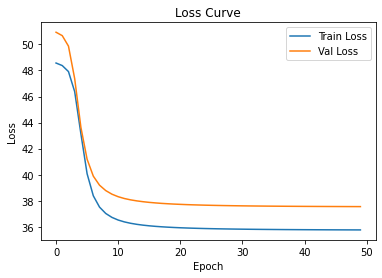

In [18]:
if len(train_losses) > 1:
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

# Evaluation on Let It Be

In [19]:
test_set_indices = [0]
test_set_params = {'context': 1, 'stride': 1}

test_set = create_CTC_dataset(data_dict=X_dict_STFT, 
                         ann_dict=ann_dict_STFT, 
                         song_dict=song_dict, 
                         song_indices=test_set_indices, 
                         dataset_params=test_set_params, 
                         dataset_description='test')

test_loader_params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0}
test_loader = torch.utils.data.DataLoader(test_set, **test_loader_params)
print(f'\nTest loader contains {len(test_loader)} mini batches.')

- LetItB added to test set. Segments: 3
Total number of segments in the test set: 3

Test loader contains 3 mini batches.


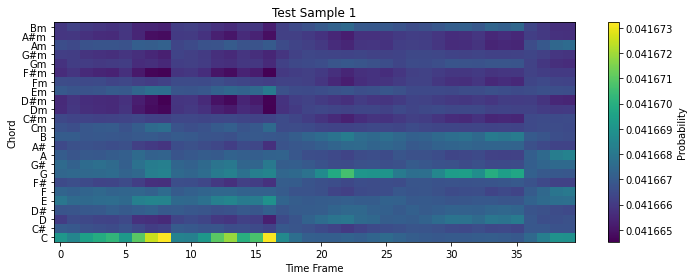

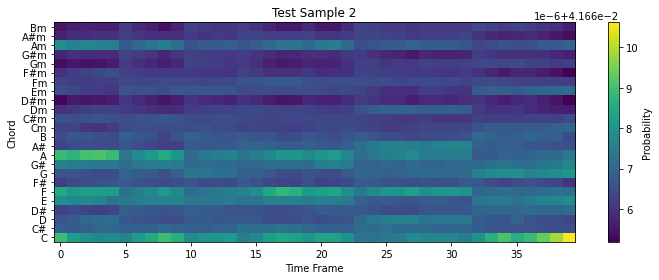

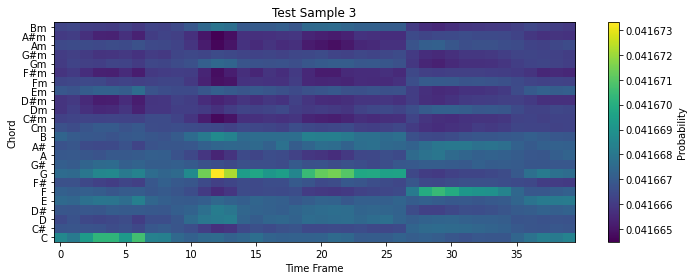

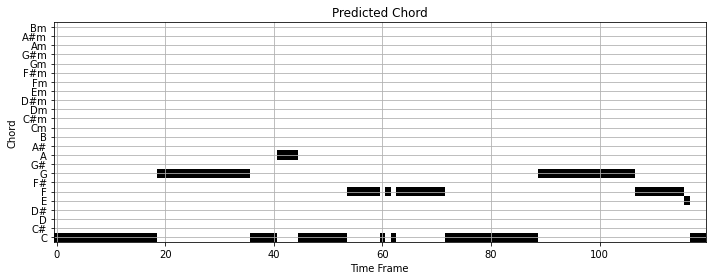

In [20]:
model_pipeline.eval()

chord_names = [
    'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B',
    'Cm', 'C#m', 'Dm', 'D#m', 'Em', 'Fm', 'F#m', 'Gm', 'G#m', 'Am', 'A#m', 'Bm'
]
all_binary_masks = []
sample_index = 0  

with torch.no_grad():
    for X_test, _, _ in test_loader:
        X_test = X_test.to(training_params['device'])
        y_pred_test = model_pipeline(X_test)  # (B, 1, T, C)
        y_pred_test = y_pred_test.squeeze(1)  # (B, T, C)
        y_pred_test_log = torch.log_softmax(y_pred_test, dim=2)
        y_pred_np = y_pred_test_log.cpu().numpy()  # (B, T, C)

        for i in range(y_pred_np.shape[0]):
            y_probs = np.exp(y_pred_np[i])        # (T, C)
            y_probs = y_probs[:, :-1]             # (T, 24)
            y_probs = y_probs.T                   # (24, T)

            y_probs /= np.sum(y_probs, axis=0, keepdims=True)

            plt.figure(figsize=(10, 4))
            im = plt.imshow(y_probs, aspect="auto", origin="lower", interpolation="none", cmap="viridis")
            plt.title(f"Test Sample {sample_index+1}")
            plt.xlabel("Time Frame")
            plt.ylabel("Chord")
            plt.yticks(ticks=np.arange(24), labels=chord_names)
            plt.colorbar(im, label="Probability")
            plt.tight_layout()
            plt.show()

            max_indices = np.argmax(y_probs, axis=0)              # shape: (T,)
            binary_mask = np.zeros_like(y_probs)                  # shape: (24, T)
            binary_mask[max_indices, np.arange(y_probs.shape[1])] = 1  
            all_binary_masks.append(binary_mask)

            sample_index += 1
    
    combined_binary_mask = np.concatenate(all_binary_masks, axis=1)  # Concatenate along time axis        
    plt.figure(figsize=(10, 4))
    im2 = plt.imshow(combined_binary_mask, aspect="auto", origin="lower", interpolation="none", cmap="gray_r")
    plt.title(f"Predicted Chord")
    plt.xlabel("Time Frame")
    plt.ylabel("Chord")
    plt.yticks(ticks=np.arange(24), labels=chord_names)
    plt.grid()
    plt.tight_layout()
    plt.show()

## Investigate Network Parameters

In [21]:
if compression_params['gamma_init'] is not None:
    print(f'{"Initial gamma:" : <25} {compression_params["gamma_init"]:.4f}')
    print(f'{"Gamma after training:" : <25} {torch.exp(model_pipeline.log_compression.log_gamma).item():.4f}')  

Initial gamma:            1.0000
Gamma after training:     5.8395


In [22]:
# Class for visualizing chord templates with zero-centered diverging colormap

# Example of making your own norm.  Also see matplotlib.colors.
# From Joe Kington: This one gives two different linear ramps:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

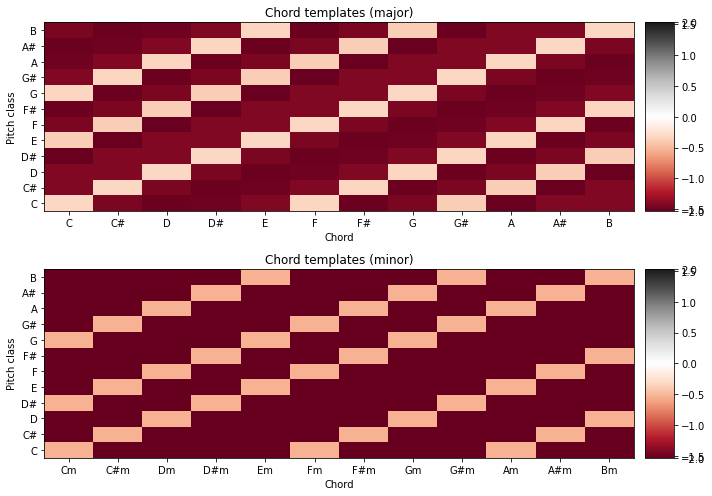

In [23]:
chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
ext_minor = 'm'
chord_labels_maj = chroma_labels
chord_labels_min = [s + ext_minor for s in chroma_labels]
chord_labels = chord_labels_maj + chord_labels_min

# read weights from layer
weights = model_pipeline.chord_recognition_templates.filter.weight.to('cpu').detach()
weights = np.squeeze(weights)

templates_maj = np.zeros((12,12))
templates_min = np.zeros((12,12))

if weights.shape[0] == 2:
    for n in range(12):           # shared weights -> templates are only shifted versions of each other
        templates_maj[:, n] = np.roll(weights[0], n)
        templates_min[:, n] = np.roll(weights[1], n)
    
elif weights.shape[0] == 24:
    templates_maj = np.asarray(weights[:12, :]).T
    templates_min = np.asarray(weights[12:, :]).T
    

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(10, 7))
    
# determine appropriate colormap for plots
if np.min([templates_maj, templates_min]) < 0:
    abs_max = np.abs([templates_maj, templates_min]).max()
    plot_parameters = {'cmap': 'RdGy', 'norm': MidpointNormalize(vmin=-abs_max, vmax=abs_max, midpoint=0, clip=False)}
else:
    plot_parameters = {'cmap': 'gray_r'}
    
# plot major chord templates
libfmp.b.plot_matrix(templates_maj, ax=[ax[0, 0], ax[0, 1]], 
                     title='Chord templates (major)',
                     ylabel='Pitch class', xlabel='Chord',
                     colorbar=True, **plot_parameters)
ax[0, 0].set_xticks(np.arange(12))
ax[0, 0].set_xticklabels(chord_labels_maj)
ax[0, 0].set_yticks(np.arange(12))
ax[0, 0].set_yticklabels(chroma_labels)

# plot minor chord templates
libfmp.b.plot_matrix(templates_min, ax=[ax[1, 0], ax[1, 1]], 
                     title='Chord templates (minor)',
                     ylabel='Pitch class', xlabel='Chord',
                     colorbar=True, **plot_parameters)
ax[1, 0].set_xticks(np.arange(12))
ax[1, 0].set_xticklabels(chord_labels_min)
ax[1, 0].set_yticks(np.arange(12))
ax[1, 0].set_yticklabels(chroma_labels)

plt.tight_layout()

In [24]:
print('C major template:\n   ' + str(weights[0, :]))
print('\nC minor template:\n   ' + str(weights[1 if weights.shape[0] == 2 else 12, :]))
print('\nC minor template:\n   ' + str(weights[1 if weights.shape[0] == 2 else 12, :]))

C major template:
   tensor([-0.3208, -1.4194, -1.4194, -1.5098, -0.3804, -1.4377, -1.5078, -0.3320,
        -1.4222, -1.4865, -1.5036, -1.4442])

C minor template:
   tensor([-0.5305, -1.5287, -1.5295, -0.5330, -1.5308, -1.5235, -1.5297, -0.5330,
        -1.5316, -1.5236, -1.5216, -1.5322])

C minor template:
   tensor([-0.5305, -1.5287, -1.5295, -0.5330, -1.5308, -1.5235, -1.5297, -0.5330,
        -1.5316, -1.5236, -1.5216, -1.5322])


### Test